<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/6.%20Redes%20Recurrentes/Practica6.1.%20Modelos%20de%20texto%3A%20codificaci%C3%B3n%20one-hot%20e%20inmersiones%20de%20palabras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 6.1. Modelos de texto

In [ ]:
from tensorflow import keras
keras.__version__

'2.4.0'

## 1. Codificación one-hot de textos

La codificación **One-hot**, que ya vimos en nuestros primeros ejemplos con Keras, es la forma más sencilla de transformar texto en vectores numéricos. 

Consiste, esencialmente, en asociar un índice entero único a cada palabra, y entonces codificar la palabra por medio de un vector de $N$ componentes ($N$ es el tamaño del vocabulario) en el que hay un 1 en la posición del índice de la palabra y 0s en el resto.

Un código ilustrativo para codificación one-hot de texto (por palabra) podría ser:

In [ ]:
import numpy as np

# Esto es nuestros datos iniciales; una entrada por "sample"
# (en este ejemplo de juguete, un "sample" es tan solo una frase, pero
# podría ser un documento entero)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Primero, construimos un indice para todos los tokens en los datos
token_index = {}
for sample in samples:
    # Simplemente tokenizamos los samples mediante el método `split.
    # En la vida real, podríamos también también eliminaríamos la puntuación
    # y los caracteres especiales de las muestras
    for word in sample.split():
        if word not in token_index:
            # Asignar un índice único a cada palabar única
            token_index[word] = len(token_index) + 1
            # Observa que no asigamos el índice 0 a nada

# A continuación, vectorizamos nuestras muestras.
# Sólo consideraremos las primeras palabras `max_length` en cada muestra.
max_length = 10

# Aquí es donde almacenamos los resultados
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        
print(results)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


Keras proporciona funciones para realizar esta codificación directamente (incluso a nivel de carácter), y es preferible usarlas porque tienen en cuenta una casuística mayor respecto a los caracteres especiales, signos de puntuación, etc. Además, estas funciones permiten definir el tamaño del vocabulario considerando únicamente las $N$ palabras más comunes del dataset e ignorando el resto.

El siguiente ejemplo muestra cómo se trabaja con las funciones proporcionadas en la librería:

In [ ]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Creamos un tokenizador, configurado para que sólo tome
# en cuenta las 1000 palabras más comunes
tokenizer = Tokenizer(num_words=1000)
# Esto construye el índice de palabras
tokenizer.fit_on_texts(samples)

# Esto convierte las cadenas en listas de índices enteros.
sequences = tokenizer.texts_to_sequences(samples)

# También se pueden obtener directamente las representaciones binarias one-hot.
# Ten en cuenta que se admiten otros modos de vectorización además de la codificación one-hot.
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# Esto es como puedes recuperar el índice de la palabra que fue computada
word_index = tokenizer.word_index
print('Hay %s tokens distintos.' % len(word_index))

Hay 9 tokens distintos.



Hay variantes similares para reducir el tamaño del vocabulario por medio de funciones hash, pero como no las usaremos, no las veremos aquí.

## 2. Inmersiones de palabras
Otra forma habitual de asociar vectores a palabras es por medio de lo que se conocen como **inmersiones de palabras** o **vectorización densa**. Mientras que los vectores que se obtienen por la codificación one-hot son binarios, muy dispersos (casi todo son 0s) y de dimensión muy alta (el tamaño del vocabulario, que es fácil que alcance las decenas de miles), las inmersiones son de dimensión baja (entre 100 y 1000, aproximadamente), y con vectores de punto flotante. Además, y a difrencia del one-hot, las inmersiones se aprenden a partir de datos.

Hay dos formas de obtener estas inmersiones:

1. Aprenderlas junto con la tarea en la que se van a utilizar (por ejemplo, clasificación de documentos o análisis de sentimientos). Se sigue un proceso similar al que hemos visto al aprender los pesos de redes neuronales.
2. Usando Transfer Learning, reutilizando un modelo de inmersión que ha sido pre-entrenado usando una tarea diferente de ML.

Veremos con detalle estos dos métodos. 

### 2.1. Inmersiones aprendidas

Como el objetivo es que la información semántica de las palabras se refleje en el vector asociado, la asignación aleatoria de vectores a palabras, aunque posible, no tiene ninguna utilidad.

El objetivo que se persigue cuando se aprende una inmersión es que las relaciones semánticas y gramaticales existentes entre las palabras del dataset se reflejen en propiedades geométricas de los vectores. Así, dos palabras que tengan un uso/significado similar deberían asociarse a vectores cercanos.

Incluso, más allá de la simple distancia, sería deseable que las direcciones vectoriales también tengan algún significado en la inmersión. Cuando hacemos inmersiones de palabras de datasets del mundo real, resulta que las direcciones se asocian a conceptos como “plural” o “género”. Por ejemplo, si sumamos el vector “femenino” al vector asociado a la palabra “rey”, deberíamos obtener el vector asociado a la palabra “reina”, o si le sumamos el vector “plural”, obtenemos el vector asociado a la palabra “reyes”.

<img src="https://2.bp.blogspot.com/-yL_425HS2ck/WEDZLk5cq0I/AAAAAAAABcI/kwy4F4Cmfi4jyG_InIiYu6F7y2-BKTXWQCLcB/s640/embedding-mnist.gif" />

Estas características no son extrapolables a todos los problemas, y dependen de la tarea concreta que queremos resolver, así pues tiene sentido entrenar la inmersión dependiendo del tipo de tarea a resolver. Para ello Keras introduce un tipo de capa llamada *embedding*.

In [ ]:
from keras.layers import Embedding

# Las capas de tipo Embedding toman al menos dos argumentos:
# el número de posibles tokens, y la dimensión de inmersión.
embedding_layer = Embedding(1000, 64)

Una capa *embedding* actúa como un diccionario que asocia índices enteros (palabras) a vectores densos. Formalmente, toma tensores 2D de enteros de tamaño `(samples, sequence_length)`, donde una entrada es una secuencia de enteros, y devuelve un tensor 3D de punto flotante de tamaño `(samples, sequence_length, embedding_dimensionality)`. Este tensor 3D puede ser procesado por las capas adecuadas (por ejemplo, una capa RNN o 1D-convolucional, como veremos más adelante).

Cuando se instancia una capa de inmersión, sus pesos (diccionario interno de vectores) se inician aleatoriamente, como en cualquier otra capa. Durante el entrenamiento, estos vectores se ajustan gradualmente por medio de la retropropagación, convirtiendo el espacio de vectores en algo que el modelo puede aprovechar. Una vez entrenado, el espacio de inmersión muestra una esctructura que refleja su especialización para el problema específico para el que ha sido entrenado.

Vamos a aplicar esta idea al problema de análisis de sentimientos de las opniones de IMDB que vimos al principio del curso. Vamos a restringirnos solamente a las 10.000 palabras más frecuentes que aparecen en las opiniones, y de cada opinión nos vamos a fijar únicamente en las primeras 20 palabras. La inmersión la haremos sobre un espacio de dimensión muy pequeña, 8D (cada palabra se convierte en un vector denso de 8 posiciones), posteriormente aplanamos esta información, y se la pasamos a una capa densa simple unitaria que realizará la clasificación:

In [ ]:
from keras.datasets import imdb
from keras import preprocessing

# Número de palabras a considerar como features
max_features = 10000
# Cortar textos después de este número de palabras
# (entre las características más comunes de max_features palabras)
maxlen = 20

# Cargar los datos como listas de enteros.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Esto convierte nuestras listas de enteros
# en un tensor de forma 2D entero `(samples, maxlen)``
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

Creamos el modelo con la capa de inmersión, y realizamos el entrenamiento con los datos leídos:
![](https://github.com/miguelamda/DL/blob/master/6.%20Redes%20Recurrentes/model1_plot.png?raw=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils.vis_utils import plot_model

model = Sequential()
# Especificamos la longitud máxima de entrada a nuestra capa de embedding
# para que luego podamos aplanar las entradas inmersas
model.add(Embedding(10000, 8, input_length=maxlen))
# Después de la capa de embedding, 
# nuestras activaciones tienen forma `(samples, maxlen, 8)`.

# Aplanamos el tensor 3D de los embeddings
# en un tensor de forma 2D `(muestras, maxlen * 8)``
model.add(Flatten())

# Añadimos el clasificador en la parte superior
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
#plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6703 - acc: 0.6144 - val_loss: 0.6208 - val_acc: 0.6966
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5419 - acc: 0.7510 - val_loss: 0.5264 - val_acc: 0.7320
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4625 - acc: 0.7853 - val_loss: 0.5010 - va

Se consigue una precisión de validación que ronda el ~75%, lo que no está nada mal teniendo en cuenta que solo usamos 20 palabras de cada opinión (comprueba que si subes a 50, la validación alcanza el 80%). 

El modelo que hemos creado no es muy ajustado, ya que al poner una sola capa densa tras aplanar los datos hace que la posición que ocupa cada palabra no tenga ningún peso en el entrenamiento, y al perder la estructura de las frases se pierde la semántica y solo considera la aparición de ellas (por ejemplo, estas frases, que en inglés significan cosas muy distintas, las considera prácticamente iguales _“this movie is shit”_ y _“this movie is the shit”_). Para evitar este problema sería necesario usar una estructura de red que sí considerase la distribución espacial de las palabras, tal y como las convolucionales 2D hacen con las imágenes. Más adelante veremos cómo aplicar a este problema capas recurrentes o 1D convolucionales.

### 2.2. Uso de inmersiones preentrenadas

Para obtener buenos resultados en inmersiones es necesario disponer de muchos datos, pero cuando los datos que tenemos no son suficientes podemos reusar el entrenamiento realizado en otras tareas, tal y como vimos en módulos anteriores. 

Al igual que las primeras capas convolucionales de una CNN preentrenada en clases genéricas reflejan relaciones generales útiles acerca de tareas de visión para muchas otras tareas, cuando tratamos con textos, si la tarea en la que se ha entrenado la inmersión no es muy subjetiva, las relaciones geométricas de los vectores de dicha inmersión reflejarán relaciones semánticas generales entre las palabras, que muy probablemente puedan ser útiles para otras tareas que usan el mismo vocabulario.

Este tipo de inmersiones de palabras normalmente se contruyen a partir de estadísticas de ocurrencias de palabras (observaciones acerca de qué palabras co-ocurren en frases y documentos), usando diversas técnicas, algunas relacionadas con redes neuronales y otras que no. 

La idea de una inmersión de palabras densa y de baja dimensión, calculada de forma no supervisada fue inicialmente explorada por Bengio et al. a principios de los 2000, pero su uso real explotó a raíz del esquema de inmersión [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), desarrollado por Mikolov en Google en 2013, que captura propiedades semánticas tales como el género, número, sinonomia, etc.

Hay varias bases de datos de inmersiones preentrenadas que se pueden descargar y usar desde las capas de inmersiones de Keras. Word2Vec es una de ellas, y [GloVe (“Global Vectors for Word Representation”)](https://nlp.stanford.edu/projects/glove/) es otra, desarrollada por investigadores de Stanford en 2014, que hace uso de factorización de matrices sobre estadísticas de co-ocurrencias a partir de millones de tokens extraídos de fuentes como la Wikipedia o Common Crawl. Puedes visualizar la inmersión en un espacio tri-dimensional en esta web https://projector.tensorflow.org.

Vamos a mostrar cómo usar GloVe en Keras, pero el procedimiento que seguiremos es extrapolable a Word2Vec y otras inmersiones.

### 2.3. Del texto en bruto a las inmersiones de palabras

Vamos a usar un modelo similar al anterior: 
* inmersión + 
* aplanamiento + 
* capa densa, 

pero esta vez usaremos una inmersión preentrenada, y en vez de usar un paquete de IMDB pre-tokenizado, haremos todo desde el texto en bruto que proporciona IMDB.

#### Descarga de IMDB como texto

El conjunto de datos sobre el que trabajaremos se puede descargar de http://ai.stanford.edu/~amaas/data/sentiment.

En primer lugar, vamos a recolectar las opiniones individuales de entrenamiento como una lista de cadenas, una cadena para cada opinión, junto con las etiquetas asociadas (pos / neg) en una lista labels:

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xf aclImdb_v1.tar.gz

--2020-12-09 14:52:30--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.2MB/s    in 10s     

2020-12-09 14:52:41 (7.72 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import os

# indica aquí la ruta a la carpeta descargada
imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### Tokenizar los datos

A continuación vamos a vectorizar los textos que hemos recolectado, y los dividiremos en conjunto de entrenamiento y de validación, de forma similar a como hemos hecho en ejemplos anteriores.

Para poner a prueba lo buenas que son las inmersiones pre-çentrenadas, vamos a trabajar sobre un conjunto de entrenamiento especialmente pequeño, y consideraremos únicamente 200 muestras.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # Recortaremos las críticas después de 100 palabras
training_samples = 200  # Estaremos entrenando con 200 muestras
validation_samples = 10000  # Estaremos validando con 10.000 muestras
max_words = 10000  # Sólo consideraremos las 10.000 palabras más importantes del conjunto de datos

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Encontrados %s tokens únicos.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Dividir los datos en un conjunto de entrenamiento y un conjunto de validación
# Pero primero, barajar los datos, ya que empezamos a partir de los datos
# donde se ordenan las muestras (todas negativas primero, luego todas positivas).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Encontrados 88582 tokens únicos.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### Descargando GloVe

Vamos a utilizar la inmersión preentrenada GloVe que ha sido creada a partir de la Wikipedia en inglés en 2014 https://nlp.stanford.edu/projects/glove/. Es un fichero de 822MB llamado `glove.6B.zip`, y contiene una imersión vectorial de 100D de 400.000 palabras.

#### Preprocesando la inmersión

El fichero anterior es un `txt` que debe ser procesado para construir la asociación entre palabras (cadenas) y vectores.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

--2020-12-09 14:54:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-09 14:54:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-09 14:54:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# indica aquí la ruta a la carpeta descargada
glove_dir = 'glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Encontrados %s word vectors.' % len(embeddings_index))

Encontrados 400000 word vectors.


A continuación, hemos de construir la matriz que cargaremos en la capa de inmersión. Debe tener tamaño `(max_words, embedding_dim)`, donde cada entrada $i$ contiene el vector de tamaño `embedding_dim` para la palabra $i$-ésima en el índice (construido durante la tokenización). El índice 0 no se usa para ninguna palabra.

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Las palabras no encontradas en el índice de embedding será todo cero.
            embedding_matrix[i] = embedding_vector

#### Definiendo el modelo

Usaremos la misma arquitectura que en el modelo anterior:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Cargando la inmersión GloVe en el modelo

La capa de inmersión tiene una matriz simple, 2D, de coma flotante, en la que cada entrada $i$ es el vector asociado a la $i$-ésima palabra. Basta cargar la matriz GloVe que hemos preparado antes en la capa de inmersión, que es la primera del modelo:

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Además, hemos de congelar los pesos de esta capa, para que el entrenamiento posterior no modifique los vectores precargados.

#### Entrenamiento y Evaluación

Compilemos y entrenemos el modelo (y lo grabamos):

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 91ms/step - loss: 1.9221 - acc: 0.5350 - val_loss: 0.7912 - val_acc: 0.4934
Epoch 2/10
7/7 [==============================] - 1s 74ms/step - loss: 0.5473 - acc: 0.6750 - val_loss: 0.9515 - val_acc: 0.4927
Epoch 3/10
7/7 [==============================] - 1s 72ms/step - loss: 0.5449 - acc: 0.7100 - val_loss: 0.6803 - val_acc: 0.5710
Epoch 4/10
7/7 [==============================] - 1s 77ms/step - loss: 0.3503 - acc: 0.8600 - val_loss: 0.6870 - val_acc: 0.5698
Epoch 5/10
7/7 [==============================] - 1s 74ms/step - loss: 0.2301 - acc: 0.9450 - val_loss: 1.1413 - val_acc: 0.4934
Epoch 6/10
7/7 [==============================] - 1s 72ms/step - loss: 0.2018 - acc: 0.9450 - val_loss: 0.7608 - val_acc: 0.5636
Epoch 7/10
7/7 [==============================] - 1s 76ms/step - loss: 0.2050 - acc: 0.9050 - val_loss: 1.6640 - val_acc: 0.4927
Epoch 8/10
7/7 [==============================] - 1s 74ms/step - loss: 0.1615 - acc: 0.9250 - val

Y mostramos su rendimiento:

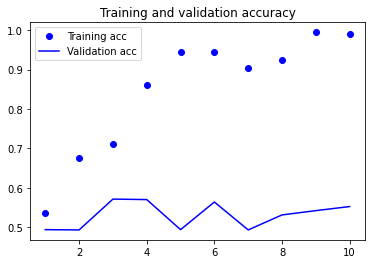

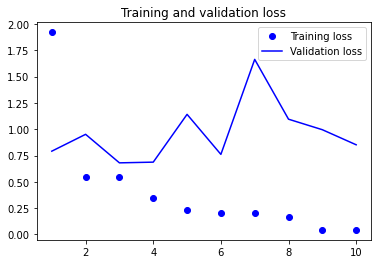

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

El modelo se sobreajusta muy rápido, algo que no es extraño teniendo en cuenta el tamaño reducido del conjunto de entrenamiento. Consecuentemente, la validación tiene una alta varianza y apenas supera el 55% en el mejor de los casos.

Nota que, debido a la selección aleatoria del pequeño conjunto de entrenamiento, los resultados pueden variar mucho si se vuelve a ejecutar el procedimiento.

También podemos intentar realizar el entrenamiento sin haber precargado una inmersión y sin congelar la capa de inmersión. Es decir, aprendiendo la inmersión específica de la tarea que estamos llevando a cabo. Esta opción, como comentamos, suele ser mejor si se dispone de los recursos computacionales necesarios y de muchos datos, pero nosotros lo entrenamos únicamente con 200 muestras:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 99ms/step - loss: 0.6883 - acc: 0.5450 - val_loss: 0.6932 - val_acc: 0.5162
Epoch 2/10
7/7 [==============================] - 1s 78ms/step - loss: 0.4814 - acc: 0.9750 - val_loss: 0.7205 - 

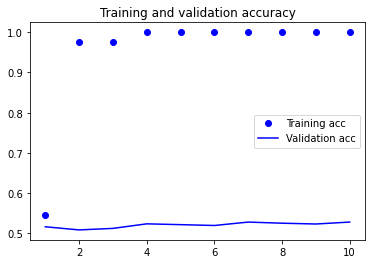

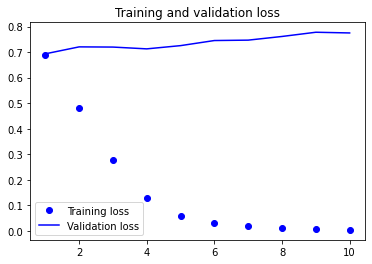

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

En este caso, la accuracy en validación se para alrededor del 50%, pero porque el conjunto de entrenamiento es extremadamente pequeño para la tarea. Si aumentáramos el conjunto de entrenamiento considerablemente, veriamos que esta opción es mejor.

Finalmente, evaluemos el modelo sobre los datos de test, que también habrá que preprocesar adecuadamente:

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Recarguemos el modelo (que fue machacado con el entrenamiento de prueba anterior), y evaluemos:

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.8466 - acc: 0.5521


[0.8466022610664368, 0.552079975605011]

Apenas conseguimos un 56% de accuracy, un valor muy bajo que nos indica que en efecto trabajar con tan pocos ejemplos de entrenamiento lo convierte en una tarea dura... y quizás la aproximación no es la más adecuada porque ignoramos el orden de las palabras en las muestras.